# Setup

In [1]:
import random
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sunpy.visualization.colormaps.color_tables as ct
import astropy.units as u

import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *

In [4]:
pd.set_option("display.width", 1000)

# Data Processing

In [5]:
df = prepare_dataset(paths["fits_root"], paths["masks_root"])[0]

⚠ Duplicate keys in FITS:
                 key                                          fits_path
29502  20160113_2056  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/13...
29274  20160113_2056  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/13...
28049  20160120_2258  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/20...
28019  20160120_2258  /Volumes/JetDrive 330/SDO Data/FITS/2016/01/20...
22492  20160509_1952  /Volumes/JetDrive 330/SDO Data/FITS/2016/05/09...
...              ...                                                ...
7807   20170831_2354  /Volumes/JetDrive 330/SDO Data/FITS/2017/08/31...
13737  20180214_0752  /Volumes/JetDrive 330/SDO Data/FITS/2018/02/14...
13750  20180214_0752  /Volumes/JetDrive 330/SDO Data/FITS/2018/02/14...
19368  20180609_2300  /Volumes/JetDrive 330/SDO Data/FITS/2018/06/09...
19371  20180609_2300  /Volumes/JetDrive 330/SDO Data/FITS/2018/06/09...

[1564 rows x 2 columns]


In [6]:
train_df = df["20170501":"20170801"]

In [7]:
# set-wise subtraction
inf_df = df.loc[~df.index.isin(train_df.index)]

In [8]:
train_df.to_parquet("./Data/train_df.parquet")
inf_df.to_parquet("./Data/inf_df.parquet")

# Model

## Training

In [9]:
# train_model(train_df)

In [10]:
model = load_trained_model(paths["model_path"])
!notify "Model loaded"

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1763840336.118445 6033824 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1763840336.139192 6033824 service.cc:145] XLA service 0x3115686a0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763840336.139373 6033824 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1763840336.141510 6033824 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1763840336.141530 6033824 mps_client.cc:384] XLA backend will use up to 12712722432 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB



/Users/aosh/anaconda3/envs/icme3.10-nn-metal/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Plotting

In [47]:
cmap = ct.aia_color_table(u.Quantity(193, "Angstrom"))
# cmap = "gray"


def print_distance(row, smoothing_params=smoothing_params, model=model):
    s = stats(row, smoothing_params, model=model)

    print("Fourier Distance: ", s["fourier_distance"])
    print("Zernike Distance: ", s["zernike_distance"])
    print("Center CH Area Difference (non-projective): ", s["rel_area"])
    print("I over U: ", s["iou"])
    print("Dice: ", s["dice"])


def plot_mask(row, smoothing_params=smoothing_params):
    print(row)
    print_distance(row, smoothing_params)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(
        pmap_to_mask(fits_to_pmap(model, prepare_fits(row.fits_path)), smoothing_params),
        cmap=cmap,
    )
    # plt.gca().add_patch(
    #     Rectangle(
    #         [range_x[0], range_y[0]],
    #         range_x[1] - range_x[0],
    #         range_y[1] - range_y[0],
    #         linewidth=1,
    #         edgecolor="y",
    #         facecolor="none",
    #     )
    # )
    plt.title("helio-n (U-Net)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.array(PIL.Image.open(row.mask_path)), cmap=cmap)
    # plt.gca().add_patch(
    #     Rectangle(
    #         [range_x[0], range_y[0]],
    #         range_x[1] - range_x[0],
    #         range_y[1] - range_y[0],
    #         linewidth=1,
    #         edgecolor="y",
    #         facecolor="none",
    #     )
    # )
    plt.title("IDL")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def plot_sdo(row, smoothing_params):
    print(row)
    print_distance(row, smoothing_params)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(prepare_fits(row.fits_path), cmap=cmap)
    plt.contour(
        pmap_to_mask(fits_to_pmap(model, prepare_fits(row.fits_path)), smoothing_params),
        levels=[0.5],
        colors="red",
        linewidths=1.5,
    )


    plt.title("helio-n (U-Net)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prepare_fits(row.fits_path), cmap=cmap)
    plt.contour(
        np.array(prepare_mask(row.mask_path)),
        levels=[0.5],
        colors="red",
        linewidths=1.5,
    )


    plt.title("IDL")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Register your dataframes here
dfs = {
    "train": train_df,
    "inference": inf_df,
}

# 2. Widgets
df_selector = widgets.RadioButtons(
    options=list(dfs.keys()),
    value="inference",
    description="DataFrame:",
)

idx_slider = widgets.IntSlider(
    value=random.randint(0, len(dfs["train"]) - 1),
    min=0,
    max=len(dfs["train"]) - 1,
    step=1,
    description="Index:",
    continuous_update=False,
)

show_mask_checkbox = widgets.Checkbox(
    value=False,
    description="Show Mask Only",
)

# New sliders
threshold_slider = widgets.FloatSlider(
    value=smoothing_params["threshold"],
    min=0.0,
    max=1.0,
    step=0.01,
    description="Threshold",
    continuous_update=False,
)

closing_radius_slider = widgets.IntSlider(
    value=smoothing_params["closing_radius"],
    min=0,
    max=20,
    step=1,
    description="Closing R",
    continuous_update=False,
)

min_size_slider = widgets.IntSlider(
    value=smoothing_params["min_size"],
    min=0,
    max=2000,
    step=10,
    description="Min size",
    continuous_update=False,
)

hole_size_slider = widgets.FloatSlider(
    value=smoothing_params["hole_size"],
    min=0.0,
    max=5000,
    step=50,
    description="Hole area",
    continuous_update=False,
)

out = widgets.Output()


# 3. Update slider range when DF changes
def update_slider_range(change):
    df = dfs[df_selector.value]
    idx_slider.max = max(0, len(df) - 1)
    if idx_slider.value > idx_slider.max:
        idx_slider.value = idx_slider.max


df_selector.observe(update_slider_range, names="value")


# 4. Main update function
def update_plot(change=None):
    global smoothing_params
    with out:
        clear_output(wait=True)
        df = dfs[df_selector.value]
        if len(df) == 0:
            print("Selected dataframe is empty.")
            return

        row = df.iloc[idx_slider.value]

        thr = threshold_slider.value
        cr = closing_radius_slider.value
        ms = min_size_slider.value
        ha = hole_size_slider.value

        smoothing_params = {
            "threshold": thr,
            "closing_radius": cr,
            "min_size": ms,
            "hole_size": ha,
        }

        if show_mask_checkbox.value:
            # Should plot SDO + NN/IDL mask
            plot_mask(
                row,
                {
                    "threshold": thr,
                    "closing_radius": cr,
                    "min_size": ms,
                    "hole_size": ha,
                },
            )
        else:
            # Should plot just the SDO / FITS-based view
            plot_sdo(
                row,
                {
                    "threshold": thr,
                    "closing_radius": cr,
                    "min_size": ms,
                    "hole_size": ha,
                },
            )

    with open("./Config/Smoothing Params.json", "w") as f:
        json.dump(smoothing_params, f)


# 5. Hook up callbacks
idx_slider.observe(update_plot, names="value")
show_mask_checkbox.observe(update_plot, names="value")
df_selector.observe(update_plot, names="value")
threshold_slider.observe(update_plot, names="value")
closing_radius_slider.observe(update_plot, names="value")
min_size_slider.observe(update_plot, names="value")
hole_size_slider.observe(update_plot, names="value")

# 6. Display the UI
controls_top = widgets.HBox(
    [
        df_selector,
        idx_slider,
        show_mask_checkbox,
    ]
)

controls_bottom = widgets.HBox(
    [
        threshold_slider,
        closing_radius_slider,
        min_size_slider,
        hole_size_slider,
    ]
)

ui = widgets.VBox(
    [
        controls_top,
        controls_bottom,
        out,
    ]
)

display(ui)

# Initial draw
update_slider_range(None)
update_plot(None)

In [46]:
row = df.iloc[0]

In [40]:
img = prepare_fits(row.fits_path)
pmap = fits_to_pmap(model, img, resize=True)
mask = pmap_to_mask(pmap)

In [41]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

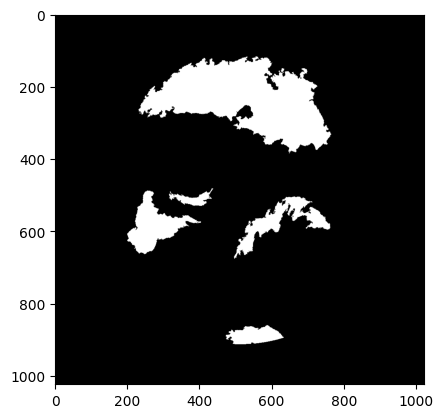

In [25]:
plt.imshow(np.array(PIL.Image.open(row.mask_path)), cmap="gray")

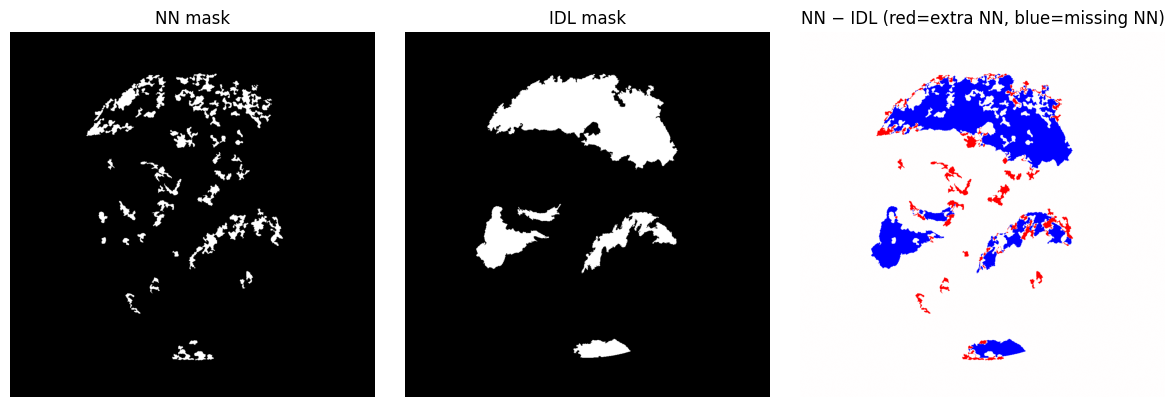

In [43]:
# ensure float or int, not bool
m_nn_i  = m_nn.astype(int)
m_idl_i = m_idl.astype(int)

diff = m_nn_i - m_idl_i

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(m_nn,  cmap="gray"); plt.title("NN mask");  plt.axis("off")
plt.subplot(1,3,2); plt.imshow(m_idl, cmap="gray"); plt.title("IDL mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(diff, cmap="bwr", vmin=-1, vmax=1)
plt.title("NN − IDL (red=extra NN, blue=missing NN)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
# inf_df["nn_map"] = inf_df.apply(lambda x: mask_via_pmap(prepare_fits(x.fits_path)), axis=1)

In [18]:
# inf_df["stats"] = inf_df.apply(lambda x: stats(x, m2=x.nn_map), axis=1)

In [19]:
def plot_with_polarity(row, smoothing_params, B_thresh=0.15):
    """
    row: DataFrame row with row.fits_path and row.mask_path and row.hmi_path (JPG)
    smoothing_params: mask-via-model parameters
    """

    aia = prepare_fits(row.fits_path)  # (1024×1024, normalized)
    hmi = prepare_hmi_jpg()  # upscale JPG → match AIA grid

    nn_mask_raw = mask_via_pmap(row, smoothing_params)
    nn_mask = nn_mask_raw > 0.5

    idl_mask_raw = prepare_mask(row.mask_path)
    idl_mask = idl_mask_raw > 0.5

    # polarity masks using pseudo-HMI field
    nn_pos = nn_mask & (hmi >= B_thresh)
    nn_neg = nn_mask & (hmi <= -B_thresh)

    idl_pos = idl_mask & (hmi >= B_thresh)
    idl_neg = idl_mask & (hmi <= -B_thresh)

    # build RGBA overlays
    def make_overlay(pos, neg, alpha=0.5):
        h, w = pos.shape
        rgba_pos = np.zeros((h, w, 4), dtype=np.float32)
        rgba_neg = np.zeros((h, w, 4), dtype=np.float32)

        rgba_pos[..., 0] = 1.0  # red
        rgba_pos[..., 3] = alpha * pos.astype(float)

        rgba_neg[..., 2] = 1.0  # blue
        rgba_neg[..., 3] = alpha * neg.astype(float)

        return rgba_pos, rgba_neg

    nn_overlay_pos, nn_overlay_neg = make_overlay(nn_pos, nn_neg)
    idl_overlay_pos, idl_overlay_neg = make_overlay(idl_pos, idl_neg)

    # plots
    print_distance(row, smoothing_params)
    plt.figure(figsize=(10, 5))

    # ------------------ U-Net ------------------
    plt.subplot(1, 2, 1)
    plt.imshow(aia, cmap=cmap)
    plt.contour(nn_mask.astype(float), levels=[0.5], colors="red")
    plt.imshow(nn_overlay_pos)
    plt.imshow(nn_overlay_neg)
    plt.title("helio-n: red=+, blue=-")
    plt.axis("off")

    # ------------------ IDL ------------------
    plt.subplot(1, 2, 2)
    plt.imshow(aia, cmap=cmap)
    plt.contour(idl_mask.astype(float), levels=[0.5], colors="red")
    plt.imshow(idl_overlay_pos)
    plt.imshow(idl_overlay_neg)
    plt.title("IDL: red=+, blue=-")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [20]:
plot_with_polarity(inf_df.iloc[13385], smoothing_params)

OSError: image file is truncated (66 bytes not processed)